## TC 5033
### Word Embeddings

<br>

#### Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested.

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%):
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


#### Install libraries (if needed)

## Import libraries

In [4]:
import numpy

import torch
from torchtext.datasets import AG_NEWS

from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset

from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt
import scikitplot as skplt
import gc

/Users/cesarivp/Documents/GitHub/pedreros_advanced_machine_learning/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [6]:
train_dataset, test_dataset = AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [7]:
tokeniser = get_tokenizer('basic_english')

In [8]:
def yield_tokens(data):
    """
    Generator function that yields tokenized text from an iterable dataset.

    Args:
        data (iterable): An iterable containing tuples where the second element is a text string.

    Yields:
        list: A list of tokens produced by the `tokeniser` function.

    Example:
        data = [(1, "Hello world"), (2, "Machine learning is fun")]
        tokens = list(yield_tokens(data))
    """
    for _, text in data:
        yield tokeniser(text)

In [9]:
UNKNOWN_TOKEN = "<unk>"

In [10]:
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=[UNKNOWN_TOKEN])
vocab.set_default_index(vocab[UNKNOWN_TOKEN])

In [11]:
#test tokens
tokens = tokeniser('Welcome to TC5033')
print(tokens, vocab(tokens))

['welcome', 'to', 'tc5033'] [3314, 4, 0]


In [12]:
NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [13]:
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [14]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


In [15]:
labels =  ["World", "Sports", "Business", "Sci/Tech"]
max_tokens = 50
BATCH_SIZE = 256

In [16]:
def collate_batch(batch):
    """
    Processes a batch of data by tokenizing text, converting tokens to indices using a vocabulary,
    and padding/truncating sequences to a fixed length.

    Args:
        batch (list of tuples): A list of (label, text) pairs.

    Returns:
        tuple:
            - torch.Tensor: A tensor of tokenized and padded/truncated text sequences (int32).
            - torch.Tensor: A tensor of labels (int32), adjusted to be zero-indexed.

    Example:
        batch = [(1, "Hello world"), (2, "Deep learning is cool")]
        x, y = collate_batch(batch)
    """
    y, x = list(zip(*batch))

    x = [vocab(tokeniser(text)) for text in x]
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    return torch.tensor(x, dtype=torch.int32), torch.tensor(y, dtype=torch.int32) - 1

In [17]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)

### Let us build our RNN model

In [18]:
EMBEDDING_SIZE = 300
NEURONS = 128
LAYERS = 2
NUM_CLASSES = 4

As for the explanation of the RNN vs GRU vS LSTM, RNNs are simple networks for sequential data but struggle with long-term dependencies. GRUs improve on RNNs by using gates to control information flow, making them faster to train. LSTMs are more complex, with additional gates to better capture long-term dependencies, usually outperforming both RNNs and GRUs on more complex tasks.

![img](https://miro.medium.com/v2/resize:fit:850/1*AeKfV2uAPeMg9j8HhQZk2w.png)

For this exercise, we'll build a GRU model.

In [19]:
class RecurrentModel(nn.Module):
    """
    A recurrent neural network (RNN) model for text classification.
    You can choose between RNN, GRU, or LSTM for the recurrent layer.

    Args:
        embed_size (int): Dimension of word embeddings.
        hidden (int): Number of hidden units in the recurrent layer.
        layers (int): Number of recurrent layers.
        num_classes (int): Number of output classes.
        rnn_type (str): The type of recurrent layer ('rnn', 'gru', 'lstm').

    Attributes:
        embedding_layer (nn.Embedding): Embedding layer mapping token indices to dense vectors.
        rnn (nn.Module): Recurrent layer (RNN, GRU, or LSTM).
        fc (nn.Linear): Fully connected layer for classification.
    """
    def __init__(self, embed_size, hidden, layers, num_classes, rnn_type='rnn'):
        super().__init__()
        
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab),
                                            embedding_dim=embed_size)

        if rnn_type == 'rnn':
            self.rnn = nn.RNN(input_size=embed_size,
                              hidden_size=hidden,
                              num_layers=layers,
                              batch_first=True,
                              dropout=0.5)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(input_size=embed_size,
                              hidden_size=hidden,
                              num_layers=layers,
                              batch_first=True,
                              dropout=0.5)
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM(input_size=embed_size,
                               hidden_size=hidden,
                               num_layers=layers,
                               batch_first=True,
                               dropout=0.5)
        else:
            raise ValueError(f"Invalid rnn_type '{rnn_type}'. Choose from 'rnn', 'gru', or 'lstm'.")

        self.fc = nn.Linear(hidden, num_classes)

    def forward(self, x):
        embedded = self.embedding_layer(x)

        if isinstance(self.rnn, nn.LSTM):
            rnn_out, (hn, cn) = self.rnn(embedded)
            final_hidden_state = hn[-1, :, :]
        else:
            rnn_out, _ = self.rnn(embedded)
            final_hidden_state = rnn_out[:, -1, :]

        out = self.fc(final_hidden_state)
        return out

In [20]:
def accuracy(model, loader):
    """
    Computes the accuracy of a given model on a dataset.

    Args:
        model (nn.Module): The trained model to evaluate.
        loader (DataLoader): DataLoader providing batches of (text, labels).

    Returns:
        float: The accuracy of the model, calculated as (correct predictions / total samples).

    Process:
        - The model is set to evaluation mode.
        - Iterates through the dataset without computing gradients.
        - Passes input text through the model to obtain predictions.
        - Compares predicted labels to actual labels and counts correct predictions.
        - Computes the overall accuracy.

    Example:
        acc = accuracy(trained_model, test_loader)
        print(f"Test Accuracy: {acc:.2%}")
    """
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for text, labels in loader:
            text, labels = text.to(device), labels.to(device)
            outputs = model(text)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [ ]:
def train(model, optimiser, epochs=100):
    """
    Trains a neural network model using cross-entropy loss.

    Args:
        model (nn.Module): The model to be trained.
        optimiser (torch.optim.Optimizer): The optimizer used for updating model weights.
        epochs (int, optional): Number of training epochs (default: 100).

    Process:
        - Sets the model to training mode.
        - Iterates over the dataset for the specified number of epochs.
        - Computes the cross-entropy loss for each batch.
        - Performs backpropagation and updates model weights.
        - Prints the average loss per epoch.

    Example:
        train(model, optimiser, epochs=50)

    Notes:
        - Assumes `train_loader` is a DataLoader providing (text, labels) batches.
        - Assumes `device` is defined (e.g., `"cuda"` or `"cpu"`).
    """
    model.train()
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        total_loss = 0
        for text, labels in train_loader:
            text, labels = text.to(device), labels.to(device)

            labels = labels.long()

            optimiser.zero_grad()

            outputs = model(text)
            loss = criterion(outputs, labels)

            loss.backward()
            optimiser.step()

            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Average loss: {average_loss:.4f}")


In [22]:
def train_model(epochs, model, optimiser):
  train(model, optimiser=optimiser,  epochs=epochs)
  print(f'Accuracy: {accuracy(model, test_loader):.4f}')

### RNN model:

In [43]:
lr = 0.003

rnn_model = RecurrentModel(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES, rnn_type='rnn')

In [44]:
train_model(10, rnn_model, torch.optim.Adam(rnn_model.parameters(), lr=lr))

Epoch 1/10, Avereage loss: 1.3290
Epoch 2/10, Avereage loss: 1.3394
Epoch 3/10, Avereage loss: 1.2972
Epoch 4/10, Avereage loss: 1.2104
Epoch 5/10, Avereage loss: 1.2523
Epoch 6/10, Avereage loss: 1.2787
Epoch 7/10, Avereage loss: 1.2656
Epoch 8/10, Avereage loss: 1.3374
Epoch 9/10, Avereage loss: 1.2947
Epoch 10/10, Avereage loss: 1.2221
Accuracy: 0.3107


### GRU model:

In [27]:
lr = 0.001

gru_model = RecurrentModel(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES, rnn_type='gru')

In [28]:
train_model(10, gru_model, torch.optim.Adam(gru_model.parameters(), lr=lr))

Epoch 1/10, Avereage loss: 0.6072
Epoch 2/10, Avereage loss: 0.2441
Epoch 3/10, Avereage loss: 0.1698
Epoch 4/10, Avereage loss: 0.1199
Epoch 5/10, Avereage loss: 0.0849
Epoch 6/10, Avereage loss: 0.0600
Epoch 7/10, Avereage loss: 0.0449
Epoch 8/10, Avereage loss: 0.0366
Epoch 9/10, Avereage loss: 0.0270
Epoch 10/10, Avereage loss: 0.0228
Accuracy: 0.9066


### LSTM model:

In [ ]:
lr = 0.001

lstm_model = RecurrentModel(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES, rnn_type='lstm')

In [36]:
train_model(10, lstm_model, torch.optim.Adam(lstm_model.parameters(), lr=lr))

Epoch 1/10, Avereage loss: 0.7479
Epoch 2/10, Avereage loss: 0.3026
Epoch 3/10, Avereage loss: 0.2146
Epoch 4/10, Avereage loss: 0.1617
Epoch 5/10, Avereage loss: 0.1241
Epoch 6/10, Avereage loss: 0.0947
Epoch 7/10, Avereage loss: 0.0736
Epoch 8/10, Avereage loss: 0.0614
Epoch 9/10, Avereage loss: 0.0478
Epoch 10/10, Avereage loss: 0.0399
Accuracy: 0.9029


## Sampling & confusion matrix

In [37]:
NUM_SAMPLES = 5

In [38]:
def sample_text(model, loader):
    """
    Generates sample predictions from a trained model on a batch of text.

    Args:
        model (nn.Module): The trained model for text classification.
        loader (DataLoader): DataLoader providing batches of (text, labels).

    Process:
        - Sets the model to evaluation mode.
        - Takes a batch of text data from the loader.
        - Passes the text through the model to generate predictions.
        - Decodes token indices back to words using the vocabulary.
        - Collects a fixed number of samples and prints the results.

    Returns:
        None (prints sample text, actual labels, and predicted labels).

    Example:
        sample_text(trained_model, test_loader)

    Notes:
        - Assumes `NUM_SAMPLES` is defined, determining how many samples to display.
        - Assumes `device` is set (e.g., `"cuda"` or `"cpu"`).
        - Assumes `vocab.get_itos()` provides a mapping from token indices to words.
    """
    model.eval()
    samples = []

    with torch.no_grad():
        for text, labels in loader:
            text, labels = text.to(device), labels.to(device)
            outputs = model(text)
            _, predicted = torch.max(outputs, 1)
            
            for i in range(NUM_SAMPLES):
                sample_text = " ".join([vocab.get_itos()[idx] for idx in text[i].tolist() if idx != 0])
                samples.append((sample_text, labels[i].item(), predicted[i].item()))
            break
    
    print("\nPredictions:")
    for text, actual, pred in samples:
        print(f"Text: {text}\nActual: {labels[actual]}\nPredicted: {labels[pred]}\n\n")

In [39]:
def plot_confusion_matrix(model_input, test_loader_input):
    """
    Plots a normalized confusion matrix for a given model and test data loader.

    Args:
        model_input (nn.Module): The trained model to evaluate.
        test_loader_input (DataLoader): DataLoader providing test data batches.

    Process:
        - Sets the model to evaluation mode.
        - Iterates over the test dataset, collecting true and predicted labels.
        - Uses scikit-plot to generate a normalized confusion matrix.
        - Displays the confusion matrix and releases unused memory.

    Notes:
        - Assumes `device` is defined (e.g., `"cuda"` or `"cpu"`).
        - Assumes the classification problem has 4 classes (`labels=[0, 1, 2, 3]`).
        - Modify the `labels` parameter if the number of classes is different.

    Example:
        plot_confusion_matrix(trained_model, test_loader)
    """
    model_input.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for text, labels in test_loader_input:
            text, labels = text.to(device), labels.to(device)
            outputs = model_input(text)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    skplt.metrics.plot_confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3], 
                                        normalize=True, title="Normalized Confusion Matrix",
                                        figsize=(8, 6))
    plt.show()
    gc.collect()   

### RNN model:


Predictions:
Text: thailand shows no easy war against wildlife crime ( reuters ) reuters - with an ak-47 assault rifle slung shoulder , roamed one of thailand ' s parks for more than a decade .
Actual: 0
Predicted: 3


Text: the great vegetarian scam ive written before about my struggle to remain a vegetarian on tuesday - when i abjure meat for religious reasons travelling .
Actual: 0
Predicted: 3


Text: has your broadband had its fiber ? falling costs , new technology , and competition , with a nudge from regulatory changes , are bringing fiber closer to homes in the us just a few years after the idea seemed all but written off .
Actual: 0
Predicted: 3


Text: wreckage of navy helicopter found the wreckage of a royal navy helicopter , which disappeared with four crew members on board , has been found off the coast of cornwall , the ministry of defence says .
Actual: 3
Predicted: 3


Text: imf sees rising oil prices having little impact on global growth tokyo rising oil prices are un

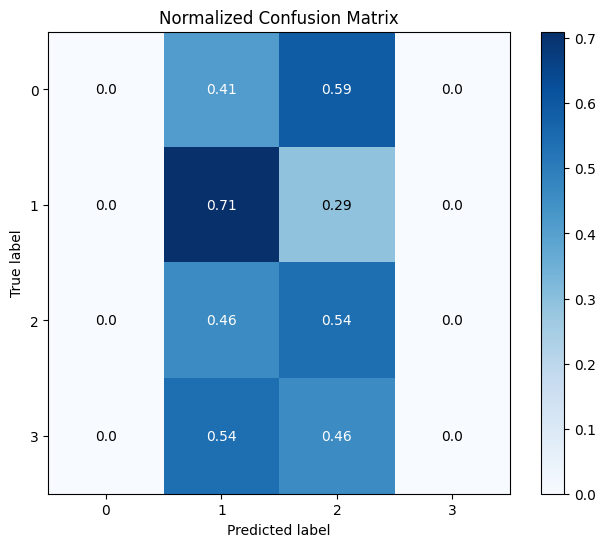

In [40]:
sample_text(rnn_model, test_loader)
plot_confusion_matrix(rnn_model, test_loader)

### GRU model:


Predictions:
Text: melrose comes up short melrose entered its thanksgiving day matchup with wakefield as an undefeated powerhouse bound for the postseason . but wakefield has tripped up the red raiders in recent years -- and yesterday was no exception .
Actual: 3
Predicted: 3


Text: fcc ok ' s company deal ( thedeal . com ) thedeal . com - arch wireless inc . can complete its #36 367 million acquisition of holdings inc .
Actual: 0
Predicted: 0


Text: dimon solidifies control at nation #39 s second-largest bank new york ( cbs . mw ) -- dina dublon is resigning as chief financial officer after 23 years at jp morgan chase in a shakeup that further solidifies jamie dimon #39 s control at the nation #39 s second-biggest bank
Actual: 2
Predicted: 2


Text: putin doubts date of the elections , allawi confirms it will be &lt b&gt . . . &lt /b&gt the russian president vladimir putin has expressed his doubt that the iraqi elections will be held at their due time . putin said during his meetin

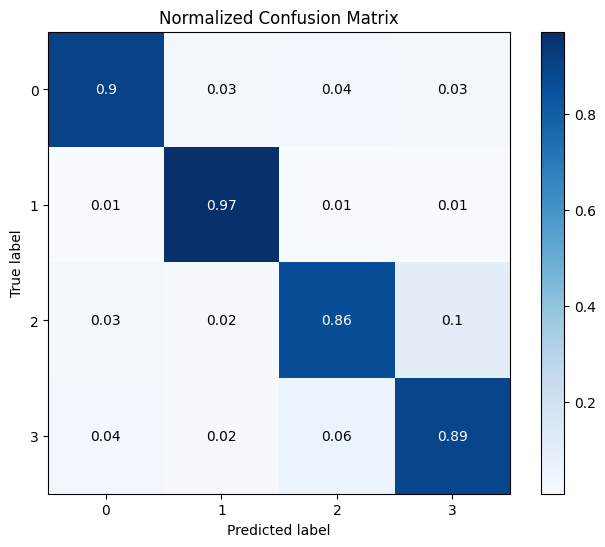

In [41]:
sample_text(gru_model, test_loader)
plot_confusion_matrix(gru_model, test_loader)

### LSTM model:


Predictions:
Text: iranian bill backs nuclear drive has passed a bill obliging the government to continue efforts to develop a nuclear energy programme . uranium enrichment can be used both for nuclear power and to make atomic bombs .
Actual: 0
Predicted: 0


Text: music firms reach out to creator of napster los angeles as a teenager , shawn fanning brought free music to the masses , creating the napster file-swapping program and unleashing a technological that granted the wishes of fans seeking virtually any song at any time - .
Actual: 3
Predicted: 3


Text: marlins streak by mets a four-day layoff fails to cool off the marlins , who extend their winning streak to eight games by beating the mets , 7-3 .
Actual: 3
Predicted: 3


Text: chip giant umc reports higher profits ( ap ) ap - united microelectronics corp . #151 the world ' s no . 2 producer of made-to-order chips #151 on wednesday reported that its third-quarter net profit more than doubled on year as shipments of chips for m

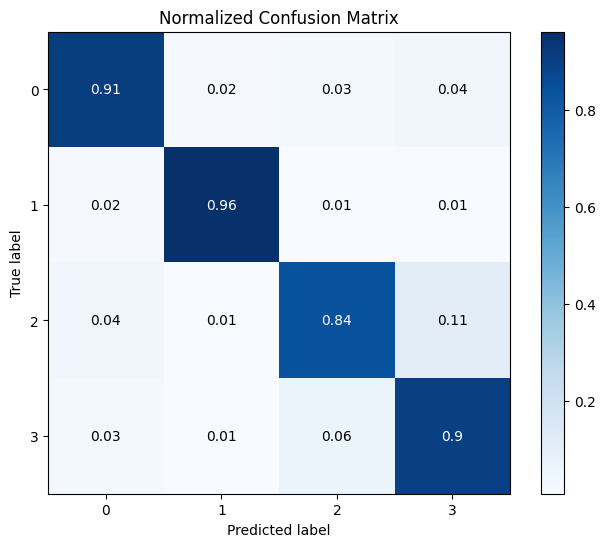

In [42]:
sample_text(lstm_model, test_loader)
plot_confusion_matrix(lstm_model, test_loader)

While both GRU and LSTM models achieved similar accuracy levels (around 90%), the RNN model performed significantly worse. This highlights the importance of memory mechanisms in models, particularly when training on sequential data, where capturing long-term dependencies is important for optimal performance.